In [1]:
from __future__ import print_function

In [2]:
from glob import glob
import numpy as np
import sys, os, h5py, time, errno, random
import GPUtil
import MDAnalysis as mda
from sklearn.cluster import DBSCAN

from CVAE import CVAE 
from utils import start_rabbit, start_worker, start_flower_monitor, read_h5py_file, cm_to_cvae, job_on_gpu
from utils import find_frame, write_pdb_frame, make_dir_p, outliers_from_cvae
from utils import omm_job, cvae_job, job_list 

Using TensorFlow backend.


In [3]:
GPU_ids = [gpu.id for gpu in GPUtil.getGPUs()] 
print('Available GPUs', GPU_ids) 

Available GPUs [0, 1]


In [51]:
top_file = None
pdb_file = os.path.abspath('./pdb/100-fs-peptide-400K.pdb')

In [5]:
# number of cvae jobs 
n_cvae = 2

# logs for scheudler

In [6]:
work_dir = os.path.abspath('./')
log_dir = os.path.join(work_dir, 'scheduler_logs') 
make_dir_p(log_dir)

In [7]:
rabbitmq_log = os.path.join(log_dir, 'rabbit_server_log.txt') 
start_rabbit(rabbitmq_log)
time.sleep(5)

celery_worker_log = os.path.join(log_dir, 'celery_worker_log.txt') 
start_worker(celery_worker_log)
start_flower_monitor() 
print('Waiting 10 seconds for the server to stablize.')
time.sleep(10)

Waiting 10 seconds for the server to stablize.


## Jobs
* Assign job_id according to the available GPUs on the board. 
* Start the simulation according the job_labels containing job_id and gpu_id for individual jobs 

In [8]:
jobs = job_list()

In [9]:
for gpu_id in GPU_ids: 
    job = omm_job(job_id=int(time.time()), gpu_id=gpu_id, top_file=top_file, pdb_file=pdb_file)
    job.start()
    print('haha')
    jobs.append(job) 
    time.sleep(2)

haha
haha


In [10]:
jobs

[<utils.omm_job at 0x7f408d1fb610>, <utils.omm_job at 0x7f408d186d10>]

# Read the output h5 files

In [11]:
print('Waiting 5 mins for omm to write contact map .h5 files. ')
time.sleep(120)

Waiting 5 mins for omm to write contact map .h5 files. 


In [12]:
cm_files = sorted(glob('omm*/*_cm.h5')) 

cm_data_lists = [read_h5py_file(cm_file) for cm_file in cm_files] 

In [13]:
cm_files

['omm_run_1543441282/output_cm.h5',
 'omm_run_1543849912/output_cm.h5',
 'omm_run_1543849914/output_cm.h5',
 'omm_run_1543863797/output_cm.h5',
 'omm_run_1543864245/output_cm.h5',
 'omm_run_1543864247/output_cm.h5',
 'omm_run_1543864552/output_cm.h5',
 'omm_run_1543864554/output_cm.h5',
 'omm_run_1543864687/output_cm.h5',
 'omm_run_1543864689/output_cm.h5',
 'omm_run_1543864780/output_cm.h5',
 'omm_run_1543864782/output_cm.h5',
 'omm_run_1543867590/output_cm.h5',
 'omm_run_1543867592/output_cm.h5',
 'omm_run_1543868438/output_cm.h5',
 'omm_run_1543868440/output_cm.h5']

# Get updates from h5 file
Once every minute

In [117]:
frame_number = lambda lists: sum([cm.shape[1] for cm in lists])
frame_number(cm_data_lists)

30493

In [15]:
frame_marker = 0 
while frame_number(cm_data_lists) < 500: 
    for cm in cm_data_lists: 
        cm.refresh() 
    if frame_number(cm_data_lists) > frame_marker: 
        print('Current number of frames from OpenMM:', frame_number(cm_data_lists)) 
        frame_marker = int((100 + frame_marker) / 100) * 100
        print('    Next report at frame', frame_marker) 
#     time.sleep(600)

# All contact to h5

In [16]:
train_data_length = [ cm_data.shape[1] for cm_data in cm_data_lists]

omm_log = os.path.join(log_dir, 'openmm_log.txt') 

log = open(omm_log, 'w') 

for i, n_frame in enumerate(train_data_length): 
    log.writelines("{} {}\n".format(cm_files[i], n_frame))    
log.close()

In [18]:
cvae_input = cm_to_cvae(cm_data_lists)

cvae_input_dir = os.path.join(work_dir, 'cvae_input') 
make_dir_p(cvae_input_dir)

cvae_input_file = os.path.join(cvae_input_dir, 'cvae_input.h5')
cvae_input_save = h5py.File(cvae_input_file, 'w')
cvae_input_save.create_dataset('contact_maps', data=cvae_input)
cvae_input_save.close() 

In [19]:
cvae_input.shape

(27037, 22, 22, 1)

# CVAE

In [20]:
hyper_dims = np.arange(n_cvae) + 3

In [21]:
# cvae_jobs = []
for i in np.arange(n_cvae): 
    cvae_j = cvae_job(time.time(), i, cvae_input_file, hyper_dim=i+3) 
    stop_jobs = jobs.get_job_from_gpu_id(i) 
    stop_jobs.stop()  
    time.sleep(2)
#     print('hehre')
    cvae_j.start() 
    jobs.append(cvae_j) 
#     cvae_jobs.append(cvae_j)
    time.sleep(2)

In [22]:
os.path.isfile(cvae_j.model_weight)

False

In [23]:
while [os.path.isfile(cvae_j.model_weight) for cvae_j in jobs.get_cvae_jobs()] != [True] * len(jobs.get_cvae_jobs()): 
    time.sleep(.5)
print('CVAE done. ') 

CVAE done. 


In [24]:
for cvae_j in jobs.get_cvae_jobs(): 
    cvae_j.state = 'FINISHED'

In [25]:
jobs.get_running_jobs()

[]

In [26]:
jobs

# CVE result

In [67]:
def predict_from_cvae(model_weight, cvae_input, hyper_dim=3): 
    os.environ["CUDA_DEVICE_ORDER"]="PCI_BUS_ID"
    os.environ["CUDA_VISIBLE_DEVICES"]=str(0)  
    cvae = CVAE(cvae_input.shape[1:], hyper_dim) 
    cvae.model.load_weights(model_weight)
    cm_predict = cvae.return_embeddings(cvae_input) 
    return cm_predict

In [68]:
model_weight = model_weights[0]
cm_predict = predict_from_cvae(model_weight, cvae_input, hyper_dim=int(model_weight[11]))

In [69]:
from mpl_toolkits.mplot3d import Axes3D

In [104]:
# db = DBSCAN(eps=0.3, min_samples=10).fit(cm_predict)
db_label = np.zeros(len(cm_predict)).astype(np.float)

In [109]:
for eps in np.arange(0.3, 2, 0.05): 
    outliers = np.squeeze(outliers_from_cvae(model_weight, cvae_input, hyper_dim=int(model_weight[11]), eps=eps))
    n_outlier = len(outliers) 
    print(n_outlier)
    db_label[outliers] = (eps*100 + 1) 
    if n_outlier <= 20: 
        break

307
158
81
35
20


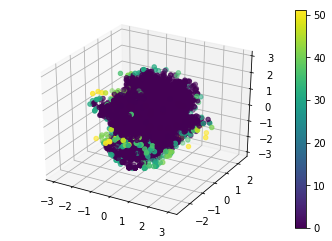

In [111]:
x, y, z = cm_predict[:,0], cm_predict[:,1], cm_predict[:,2]

fig, ax = plt.subplots(subplot_kw=dict(projection='3d'))

# ls = LightSource(270, 45)
# To use a custom hillshading mode, override the built-in shading and pass
# in the rgb colors of the shaded surface calculated from "shade".
# rgb = ls.shade(z, cmap=cm.gist_earth, vert_exag=0.1, blend_mode='soft')
sc = ax.scatter(x, y, z, c=db_label)
plt.colorbar(sc)
plt.show()

# Identifier base on CVAE result

In [27]:
# All the outliers from cvae
print('Counting outliers') 
model_weights = [cvae_j.model_weight for cvae_j in jobs.get_cvae_jobs()]
outlier_list = []
for model_weight in model_weights: 
    print('Model latent dimension: ', int(model_weight[11]))
    for eps in np.arange(0.35, 2, 0.05): 
        outliers = np.squeeze(outliers_from_cvae(model_weight, cvae_input, hyper_dim=int(model_weight[11]), eps=eps))
        n_outlier = len(outliers)
        print('dimension = {0}, eps = {1:.2f}, number of outlier found: {2}'.format(
            model_weight[11], eps, n_outlier))
        if n_outlier <= 20: 
            outlier_list.append(outliers)
            break

np.save('outlier_list.npy', np.array(outlier_list))
outlier_list_uni, outlier_count = np.unique(np.hstack(outlier_list), return_counts=True) 
# outlier_list_ulti = outlier_list_uni[np.where(outlier_count > 1)]
# print('outliers: ', outlier_list_ulti)

Counting outliers
Model latent dimension:  3
dimension = 3, eps = 0.35, number of outlier found: 158
dimension = 3, eps = 0.40, number of outlier found: 81
dimension = 3, eps = 0.45, number of outlier found: 35
dimension = 3, eps = 0.50, number of outlier found: 20
Model latent dimension:  4
dimension = 4, eps = 0.35, number of outlier found: 1656
dimension = 4, eps = 0.40, number of outlier found: 932
dimension = 4, eps = 0.45, number of outlier found: 513
dimension = 4, eps = 0.50, number of outlier found: 305
dimension = 4, eps = 0.55, number of outlier found: 150
dimension = 4, eps = 0.60, number of outlier found: 63
dimension = 4, eps = 0.65, number of outlier found: 34
dimension = 4, eps = 0.70, number of outlier found: 19


In [52]:
print('Writing pdb files') 
# write the pdb according the outlier indices
traj_info = open('./scheduler_logs/openmm_log.txt', 'r').read().split()

traj_dict = dict(zip(traj_info[::2], np.array(traj_info[1::2]).astype(int)))

outliers_pdb = os.path.join(work_dir, 'outlier_pdbs')
make_dir_p(outliers_pdb)

outlier_pdb_files = []
for outlier in outlier_list_uni: 
    traj_file, num_frame = find_frame(traj_dict, outlier) 
    print('Found outlier# {} at frame {} of {}'.format(outlier, num_frame, traj_file))
    outlier_pdb_file = os.path.join(outliers_pdb, '{}_{}_{}.pdb'.format(outlier, traj_file[:18], num_frame))
    outlier_pdb = write_pdb_frame(traj_file, pdb_file, num_frame, outlier_pdb_file) 
    outlier_pdb_files.append(outlier_pdb_file) 

Writing pdb files
Found outlier# 214 at frame 214 of omm_run_1543441282/output.dcd
Found outlier# 3668 at frame 3668 of omm_run_1543441282/output.dcd
Found outlier# 5019 at frame 5019 of omm_run_1543441282/output.dcd
Found outlier# 5374 at frame 5374 of omm_run_1543441282/output.dcd
Found outlier# 5912 at frame 5912 of omm_run_1543441282/output.dcd
Found outlier# 5923 at frame 5923 of omm_run_1543441282/output.dcd
Found outlier# 6002 at frame 6002 of omm_run_1543441282/output.dcd
Found outlier# 6717 at frame 6717 of omm_run_1543441282/output.dcd
Found outlier# 6718 at frame 6718 of omm_run_1543441282/output.dcd
Found outlier# 6719 at frame 6719 of omm_run_1543441282/output.dcd
Found outlier# 6746 at frame 6746 of omm_run_1543441282/output.dcd
Found outlier# 6924 at frame 6924 of omm_run_1543441282/output.dcd
Found outlier# 6959 at frame 6959 of omm_run_1543441282/output.dcd
Found outlier# 7021 at frame 7021 of omm_run_1543441282/output.dcd
Found outlier# 7223 at frame 7223 of omm_run_1

In [53]:
mda_traj = mda.Universe(pdb_file, traj_file)

In [55]:
outlier_traj = mda.Universe(outlier_pdb_files[0], outlier_pdb_files)

from MDAnalysis.analysis.rms import RMSD 
RMSD_Mat = []
for i in outlier_pdb_files: 
    ref_traj = mda.Universe(i)
    R = RMSD(outlier_traj, ref_traj, select = 'protein and name CA') 
    R.run()
#     print(R.rmsd[:,2].shape)
    RMSD_Mat.append(R.rmsd[:,2])

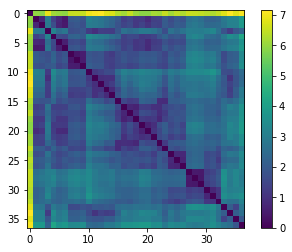

In [56]:
import matplotlib.pyplot as plt
plt.imshow(RMSD_Mat)
plt.colorbar() 
plt.savefig('rmsd.png')

In [36]:
for gpu_id in jobs.get_available_gpu(GPU_ids): 
    print(gpu_id)

0
1


In [41]:
for gpu_id in jobs.get_available_gpu(GPU_ids): 
    random.shuffle(outlier_pdb_files)
    outlier_pdb_file = outlier_pdb_files[0]
    job = omm_job(job_id=int(time.time()), gpu_id=gpu_id, top_file=top_file, pdb_file=outlier_pdb_file)
    outlier_pdb_files.remove(pdb_file) 
    job.start()
    print('haha')
    jobs.append(job) 
    time.sleep(2)

haha
haha


# New outliers

In [112]:
cm_files = sorted(glob('omm*/*_cm.h5')) 

cm_data_lists = [read_h5py_file(cm_file) for cm_file in cm_files] 

In [121]:
for cm in cm_data_lists: 
    cm.refresh() 

In [122]:
frame_number(cm_data_lists)

30665

In [119]:
train_data_length = [ cm_data.shape[1] for cm_data in cm_data_lists]

log = open(omm_log, 'w') 

for i, n_frame in enumerate(train_data_length): 
    log.writelines("{} {}\n".format(cm_files[i], n_frame))    
log.close()

In [123]:
cvae_input = cm_to_cvae(cm_data_lists)

In [125]:
cvae_input.shape

(30665, 22, 22, 1)

In [124]:
print('Counting outliers') 
model_weights = [cvae_j.model_weight for cvae_j in jobs.get_cvae_jobs()]
outlier_list = []
for model_weight in model_weights: 
    print('Model latent dimension: ', int(model_weight[11]))
    for eps in np.arange(0.35, 2, 0.05): 
        outliers = np.squeeze(outliers_from_cvae(model_weight, cvae_input, hyper_dim=int(model_weight[11]), eps=eps))
        n_outlier = len(outliers)
        print('dimension = {0}, eps = {1:.2f}, number of outlier found: {2}'.format(
            model_weight[11], eps, n_outlier))
        if n_outlier <= 20: 
            outlier_list.append(outliers)
            break

np.save('outlier_list.npy', np.array(outlier_list))
outlier_list_uni, outlier_count = np.unique(np.hstack(outlier_list), return_counts=True) 

Counting outliers
Model latent dimension:  3
dimension = 3, eps = 0.35, number of outlier found: 158
dimension = 3, eps = 0.40, number of outlier found: 81
dimension = 3, eps = 0.45, number of outlier found: 35
dimension = 3, eps = 0.50, number of outlier found: 20
Model latent dimension:  4
dimension = 4, eps = 0.35, number of outlier found: 1648
dimension = 4, eps = 0.40, number of outlier found: 928
dimension = 4, eps = 0.45, number of outlier found: 512
dimension = 4, eps = 0.50, number of outlier found: 303
dimension = 4, eps = 0.55, number of outlier found: 149
dimension = 4, eps = 0.60, number of outlier found: 62
dimension = 4, eps = 0.65, number of outlier found: 34
dimension = 4, eps = 0.70, number of outlier found: 19


In [126]:
print('Writing pdb files') 
# write the pdb according the outlier indices
traj_info = open('./scheduler_logs/openmm_log.txt', 'r').read().split()

traj_dict = dict(zip(traj_info[::2], np.array(traj_info[1::2]).astype(int)))

outliers_pdb = os.path.join(work_dir, 'outlier_pdbs')
make_dir_p(outliers_pdb)

outlier_pdb_files = []
for outlier in outlier_list_uni: 
    traj_file, num_frame = find_frame(traj_dict, outlier) 
    print('Found outlier# {} at frame {} of {}'.format(outlier, num_frame, traj_file))
    outlier_pdb_file = os.path.join(outliers_pdb, '{}_{}_{}.pdb'.format(outlier, traj_file[:18], num_frame))
    outlier_pdb = write_pdb_frame(traj_file, pdb_file, num_frame, outlier_pdb_file) 
    outlier_pdb_files.append(outlier_pdb_file) 

Writing pdb files
Found outlier# 214 at frame 214 of omm_run_1543441282/output.dcd
Found outlier# 3668 at frame 3668 of omm_run_1543441282/output.dcd
Found outlier# 5019 at frame 5019 of omm_run_1543441282/output.dcd
Found outlier# 5374 at frame 5374 of omm_run_1543441282/output.dcd
Found outlier# 5912 at frame 5912 of omm_run_1543441282/output.dcd
Found outlier# 5923 at frame 5923 of omm_run_1543441282/output.dcd
Found outlier# 6002 at frame 6002 of omm_run_1543441282/output.dcd
Found outlier# 6717 at frame 6717 of omm_run_1543441282/output.dcd
Found outlier# 6718 at frame 6718 of omm_run_1543441282/output.dcd
Found outlier# 6719 at frame 6719 of omm_run_1543441282/output.dcd
Found outlier# 6746 at frame 6746 of omm_run_1543441282/output.dcd
Found outlier# 6924 at frame 6924 of omm_run_1543441282/output.dcd
Found outlier# 6959 at frame 6959 of omm_run_1543441282/output.dcd
Found outlier# 7021 at frame 7021 of omm_run_1543441282/output.dcd
Found outlier# 7223 at frame 7223 of omm_run_1